In [1]:
import numpy as np
from glob import glob
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding, Isomap
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from graph_kernels import shortest_path_kernel
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, I load all adjacency matrices and their labels for the PPI and SHOCK data:

In [2]:
ppi_file_list = glob("./PPI/*.csv")
ppi_data = [
    np.loadtxt(file_path, delimiter=",", dtype=np.int64) for file_path in ppi_file_list
]
shock_file_list = glob("./SHOCK/*.csv")
shock_data = [
    np.loadtxt(file_path, delimiter=",", dtype=np.int64)
    for file_path in shock_file_list
]
# print(ppi_data)
ppi_labels = ppi_data[-1]
ppi_adj_matrices = np.delete(ppi_data, -1)
shock_labels = shock_data[-1]
shock_adj_matrices = np.delete(shock_data, -1)

del ppi_data, shock_data, ppi_file_list, shock_file_list

I now run the Shortest Path Kernel on the given adjacency matrices, then evaluate the similarities to calculate pairwise distances.

In [3]:
sp_kernel = shortest_path_kernel()
sp_graphs = [
    sp_kernel.compute_shortest_paths_multi_process(ppi_adj_matrices),
    sp_kernel.compute_shortest_paths_multi_process(shock_adj_matrices),
]
ks = [
    sp_kernel.compute_similarities_multi_process(sp_graphs[0]),
    sp_kernel.compute_similarities_multi_process(sp_graphs[1]),
]
distance_matrices = [
    pairwise_distances(ks[0], metric="euclidean", n_jobs=-1),
    pairwise_distances(ks[1], metric="euclidean", n_jobs=-1),
]


Follow the computed pairwise distances displayed on a 2D raster, for both datasets:

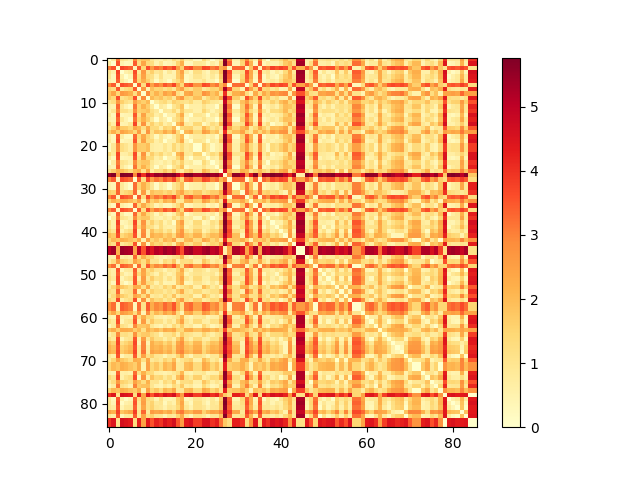

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.imshow(distance_matrices[0], zorder=2, cmap='YlOrRd', interpolation='nearest')
plt.colorbar();
plt.show()

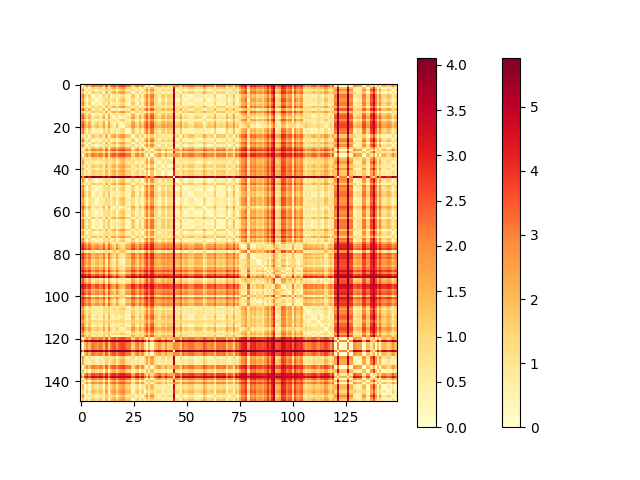

In [5]:
plt.imshow(distance_matrices[1], zorder=2, cmap='YlOrRd', interpolation='nearest')
plt.colorbar();
plt.show()

# SVM Linear Classifier
I now train an SVM model with the data transformed through my Shortest Path Kernel without any Manifold learning techniques. For simplicity and speed, we choose as parameters C = 1 and Gamma = auto, because to test the behaviour of different C and Gamma together with the chosen Manifold techniques, the execution time would increase exponentially for each possible configuration, since already with the chosen Manifolds we test different configurations of Components and Neighbours.

In [6]:
from sklearn.model_selection import StratifiedKFold

stratified_k_fold = StratifiedKFold(n_splits=10, shuffle=True)  # 10
clf = SVC(kernel="linear", C=1.0)
ppi_labels = ppi_labels.ravel()
shock_labels = shock_labels.ravel()
ppi_scores = cross_val_score(
    estimator=clf,
    X=distance_matrices[0],
    y=ppi_labels,
    cv=stratified_k_fold,
    n_jobs=-1,
    verbose=0,
)
shock_scores = cross_val_score(
    estimator=clf,
    X=distance_matrices[1],
    y=shock_labels,
    cv=stratified_k_fold,
    n_jobs=-1,
    verbose=0,
)
print(
    " ".join(
        [
            "PPI Avarage accuracy without Manifold Learning: ",
            str(np.mean(ppi_scores)),
            "\n" "SHOCK Avarage accuracy without Manifold Learning: ",
            str(np.mean(shock_scores)),
        ]
    )
)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


PPI Avarage accuracy without Manifold Learning:  0.7847222222222221 
SHOCK Avarage accuracy without Manifold Learning:  0.4333333333333333


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


As we can see the avarage accuracy on the PPI dataset is pretty good, wherease it's pretty low on the Shock one.
Now 

In [7]:
import multiprocessing
import itertools
from graph_kernels import cross_validation_analysis
# import pprint
# pp = pprint.PrettyPrinter(indent=2)

ppi_lle_results = []
shock_lle_results = []
ppi_spectral_results = []
shock_spectral_results = []

number_of_neighs_comps = 25

neigh_comps_combo = list(itertools.combinations(range(2, number_of_neighs_comps), 2))

with multiprocessing.Pool() as pool:
    ppi_lle_results = pool.map(
        cross_validation_analysis(
            manifold_technique=LocallyLinearEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[0],
            labels=ppi_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
    )
    shock_lle_results = pool.map(
        cross_validation_analysis(
            manifold_technique=LocallyLinearEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[1],
            labels=shock_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
    )
    ppi_spectral_results = pool.map(
        cross_validation_analysis(
            manifold_technique=SpectralEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[0],
            labels=ppi_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
    )
    shock_spectral_results = pool.map(
        cross_validation_analysis(
            manifold_technique=SpectralEmbedding,
            estimator=clf,
            distance_matrices=distance_matrices[1],
            labels=shock_labels,
            cv_method=stratified_k_fold,
        ),
        neigh_comps_combo,
    )


In [8]:
ppi_lle_results = np.array(ppi_lle_results)
shock_lle_results = np.array(shock_lle_results)
ppi_spectral_results = np.array(ppi_spectral_results)
shock_spectral_results = np.array(shock_spectral_results)

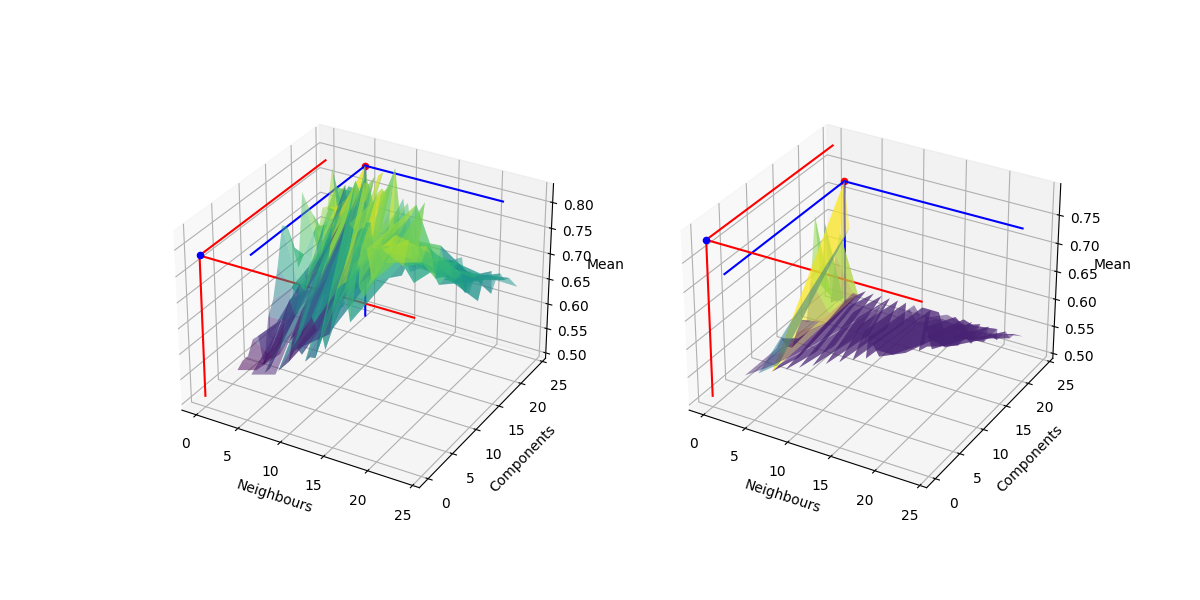

In [9]:
def compare_scores(linear_result, *manifold_results):
    if len(manifold_results) != 2:
        raise Exception("You can compare just two ")
    linear_result = np.mean(linear_result)
    fig = plt.figure(figsize=(12, 6), dpi=100)
    subaxes = [fig.add_subplot(121, projection="3d"), fig.add_subplot(122, projection="3d")]
    for i in range(0, 2):
        accuracies = manifold_results[i][:, 0].astype(float)
        neighbours = manifold_results[i][:, 1].astype(int)
        components = manifold_results[i][:, 2].astype(int)
        subaxes[i].plot_surface(
            np.reshape(neighbours, (11, 23)),
            np.reshape(components, (11, 23)),
            np.reshape(accuracies, (11, 23)),
            alpha=0.5,
            # color="yellow",
            rstride=1,
            cstride=1,
            cmap="viridis",
            edgecolor="none",
        )
        subaxes[i].set_xlabel("Neighbours")
        subaxes[i].set_ylabel("Components")
        subaxes[i].set_zlabel("Mean")

        max_mean = manifold_results[i][:, 0].astype(float).max()
        min_mean = manifold_results[i][:, 0].astype(float).min()
        index_of_max = np.where(accuracies == max_mean)[0][0]

        subaxes[i].plot(
            [neighbours[index_of_max], neighbours[index_of_max]],
            [components[index_of_max], components[index_of_max]],
            [min_mean, max_mean],
            zorder=3,
            color = "blue"
        )  # AVG ACCURACIES
        subaxes[i].plot(
            [components[index_of_max], neighbours[index_of_max]],
            [components[index_of_max], components[index_of_max]],
            [max_mean, max_mean],
            zorder=3,
            color = "blue"
        )  # NEIGHBOURS
        subaxes[i].plot(
            [neighbours[index_of_max], neighbours[index_of_max]],
            [0, components[index_of_max]],
            [max_mean, max_mean],
            zorder=3,
            color = "blue"
        )  # COMPONENTS
        subaxes[i].scatter(neighbours[index_of_max], components[index_of_max], max_mean, color = "red") # SCORE WITH MANIFOLD 
        subaxes[i].scatter(0, 0, linear_result, color = "blue") # SCORE WITHOUT MANIFOLD 

        subaxes[i].plot(
            [0, 0],
            [0, 0],
            [min_mean, linear_result],
            zorder=3,
            color = "red"
        )  # AVG ACCURACIES
        subaxes[i].plot(
            [0, number_of_neighs_comps - 1 ],
            [0, 0],
            [linear_result, linear_result],
            zorder=3,
            color = "red"
        )  # NEIGHBOURS
        subaxes[i].plot(
            [0, 0],
            [0, number_of_neighs_comps - 1],
            [linear_result, linear_result],
            zorder=3,
            color = "red"
        )  # COMPONENTS
        


compare_scores(ppi_scores, ppi_lle_results, ppi_spectral_results)

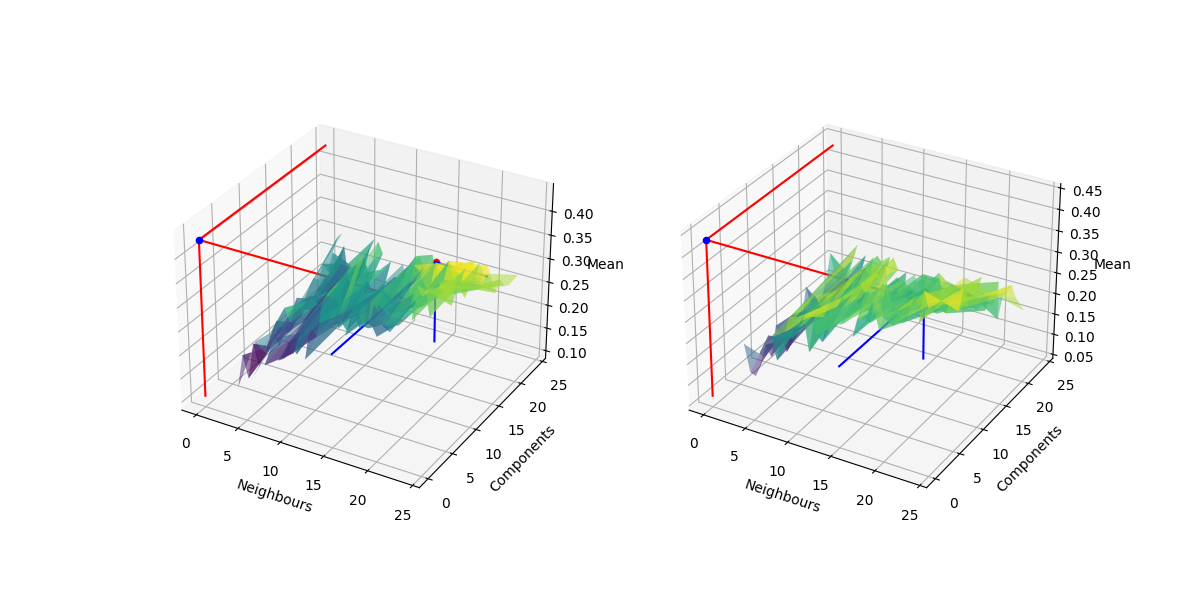

In [10]:
compare_scores(shock_scores, shock_lle_results, shock_spectral_results)

Clearly, as can be seen from the comparison graphs, the chosen manifold techniques do not add any improvement to our accuracy for the SHOCK dataset, but on the other hand they bring a slight improvement for the PPI. To get a better idea, we can also see the comparison of their average accuracies:


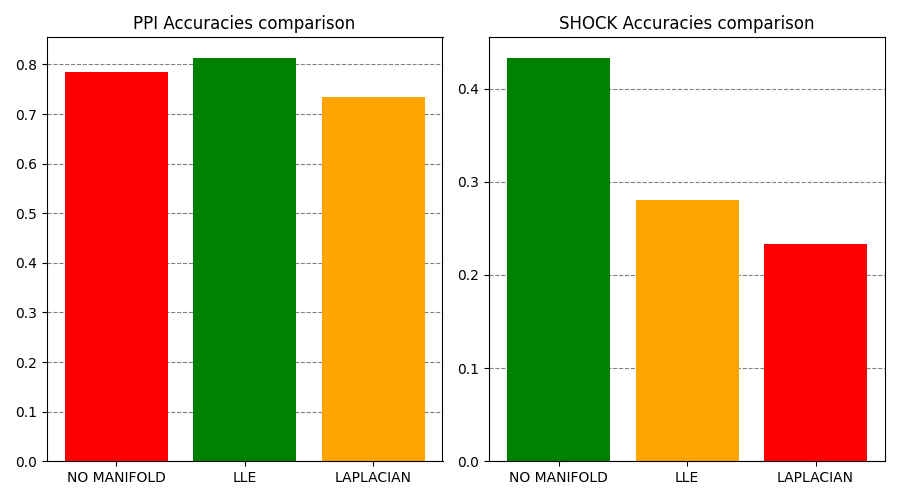

In [11]:
left = [1, 2, 3]
ppi_accuracies = [
    np.mean(ppi_scores),
    ppi_lle_results[:, 0].astype(float).max(),
    ppi_spectral_results[:, 0].astype(float).max(),
]
shock_accuracies = [
    np.mean(shock_scores),
    shock_lle_results[:, 0].astype(float).max(),
    shock_spectral_results[:, 0].astype(float).max(),
]
tick_label = ["NO MANIFOLD", "LLE", "LAPLACIAN"]

fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(9, 5)

axs[0].bar(
    left,
    ppi_accuracies,
    tick_label=tick_label,
    width=0.8,
    color=["red", "green", "orange"],
)
axs[0].set_title("PPI Accuracies comparison")
axs[0].set_axisbelow(True)
axs[0].yaxis.grid(color='gray', linestyle='dashed')

axs[1].bar(
    left,
    shock_accuracies,
    tick_label=tick_label,
    width=0.8,
    color=["green", "orange", "red"],
)
axs[1].set_title("SHOCK Accuracies comparison")
axs[1].set_axisbelow(True)
axs[1].yaxis.grid(color='gray', linestyle='dashed')

